In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate,Dot
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
import tensorflow.data
from tensorflow.keras.regularizers import L2
from joblib import load
import pydot
from datetime import datetime
from thefuzz import process

In [2]:
@tf.keras.utils.register_keras_serializable()
def split_func(input_str):
  return tf.strings.split(input_str, sep=", ")

In [3]:

studio_vectorize_layer_model=tf.keras.models.load_model('intermediate_data_all_embeddings/studio_vectorize_layer_model')
studio_vectorize_layer = studio_vectorize_layer_model.layers[0]

num_studios=len(studio_vectorize_layer.get_vocabulary())
num_studios

914

In [4]:
genre_vectorize_layer_model=tf.keras.models.load_model('intermediate_data_all_embeddings/genre_vectorize_layer_model')
genre_vectorize_layer = genre_vectorize_layer_model.layers[0]

num_genres=len(genre_vectorize_layer.get_vocabulary())
num_genres

23

In [5]:
source_vectorize_layer_model=tf.keras.models.load_model('intermediate_data_all_embeddings/source_vectorize_layer_model')
source_vectorize_layer = source_vectorize_layer_model.layers[0]


num_sources=len(source_vectorize_layer.get_vocabulary())
num_sources

19

In [6]:
user_input_shape=6

In [7]:
anime_input_shape=8

In [8]:
studio_max_length = 10

In [9]:
genre_max_length=9

In [10]:
source_max_length=1

In [2]:
df=np.load('F:/merged.npy',mmap_mode='r+')

In [3]:
df[0]

memmap([ 1.4194900e+05,  2.0000000e+01,  1.2018528e+00, -2.4250230e-01,
         3.2000000e+01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.0000000e+00,  1.8112249e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00,
         0.0000000e+00,  9.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         3.0000000e+00,  5.0000000e+00,  2.0000000e+00,  2.5000000e+01,
         3.1000000e+01,  8.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  2.0000000e+00], dtype=float32)

In [4]:
df

memmap([[ 1.4194900e+05,  2.0000000e+01,  1.2018528e+00, ...,
          0.0000000e+00,  0.0000000e+00,  2.0000000e+00],
        [ 3.3784000e+05,  5.3560000e+03,  9.4899648e-01, ...,
          0.0000000e+00,  0.0000000e+00,  5.0000000e+00],
        [ 1.8695600e+05,  9.2600000e+03, -1.1260273e+00, ...,
          0.0000000e+00,  0.0000000e+00,  7.0000000e+00],
        ...,
        [ 3.5065600e+05,  1.5750000e+03,  1.0801682e+00, ...,
          0.0000000e+00,  0.0000000e+00,  3.0000000e+00],
        [ 1.8338100e+05,  3.7450000e+04,  1.2018528e+00, ...,
          0.0000000e+00,  0.0000000e+00,  7.0000000e+00],
        [ 5.3598000e+04,  1.6011000e+04,  4.7535399e-01, ...,
          0.0000000e+00,  0.0000000e+00,  7.0000000e+00]], dtype=float32)

In [12]:
np.random.shuffle(df)

In [14]:
size=df.shape[0]

In [15]:
dfhalf1=df[0:int(size/2),:]

In [16]:
dfhalf1.shape

(29984240, 38)

In [17]:
np.save('F:/merged_half1.npy',dfhalf1)

In [18]:
dfhalf2=df[int(size/2):,:]

In [19]:
dfhalf2.shape

(29984240, 38)

In [20]:
np.save('F:/merged_half2.npy',dfhalf2)

In [24]:
df.shape

(59968480, 38)

In [11]:
df=np.load('F:/merged_half1.npy')

In [11]:
df=np.load('intermediate_data_all_embeddings/merged.npy')

In [12]:
df.shape

(23793954, 37)

In [13]:
user_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,3:9])
anime_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,9:9+anime_input_shape])
anime_studio_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape:9+anime_input_shape+studio_max_length])
anime_genre_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape+studio_max_length:9+anime_input_shape+studio_max_length+genre_max_length])
anime_source_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,-1:])
ratings_dataset = tf.data.Dataset.from_tensor_slices(df[:,2])

In [14]:
dataset = tf.data.Dataset.zip(({'user_input':user_metadata_dataset, 'anime_input':anime_metadata_dataset,'anime_genre_embedding_input':anime_genre_embedding_dataset,'anime_studio_embedding_input':anime_studio_embedding_dataset,'anime_source_embedding_input':anime_source_embedding_dataset}, ratings_dataset))


In [14]:
# Take one element from the dataset
sample_row = next(iter(dataset.take(1)))

# Print the sample row
print("Sample Row:", sample_row)

Sample Row: ({'user_input': <tf.Tensor: shape=(6,), dtype=float32, numpy=
array([-0.2425023, 32.       ,  0.       ,  0.       ,  0.       ,
        1.       ], dtype=float32)>, 'anime_input': <tf.Tensor: shape=(8,), dtype=float32, numpy=
array([1.8112249, 0.       , 0.       , 0.       , 0.       , 0.       ,
       1.       , 0.       ], dtype=float32)>, 'anime_genre_embedding_input': <tf.Tensor: shape=(13,), dtype=float32, numpy=
array([ 9.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  5.,  2., 25., 31.,  8.],
      dtype=float32)>, 'anime_studio_embedding_input': <tf.Tensor: shape=(7,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, 'anime_source_embedding_input': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>}, <tf.Tensor: shape=(), dtype=float32, numpy=1.2018528>)


In [15]:
size = dataset.cardinality().numpy()

In [16]:
size

23793954

In [17]:
#dataset=dataset.shuffle(int(size ))
train_size = int(0.99 * size)  # Assuming an 80-10-10 split
val_size =int(0.005*size)
train_dataset = dataset.take(train_size)    
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset1 = dataset.skip(train_size).skip(val_size)


In [18]:
batch_size = 16384
val_dataset=val_dataset.shuffle(2*batch_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
val_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=8>

In [20]:
batch_size = 16384
train_dataset=train_dataset.shuffle(2*batch_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
train_dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=1438>

In [22]:
def user_model(input_shape):
    input=Input(shape=(input_shape))
    x=Dense(32,activation='relu' )(input)
    # x=Dense(128,activation='relu')(x)
    # x=Dense(64,activation='relu')(x)
    output=Dense(16,activation='relu')(x)
    model = tf.keras.Model(inputs=input, outputs=output)
    return model
    
    
    


In [23]:
def anime_model(input_shape):
    input = Input(shape=(input_shape,),name='anime_inputs')
    input_genre= Input(shape=(genre_max_length,),name='anime_genre_embeddings_inputs')
    input_studio= Input(shape=(studio_max_length,),name='anime_studio_embeddings_inputs')
    input_source= Input(shape=(source_max_length,),name='anime_source_embeddings_inputs')
    genre_embedding=tf.keras.layers.Embedding(input_dim=num_genres,output_dim=16,mask_zero=True)(input_genre)
    genre_flattened = tf.keras.layers.Flatten()(genre_embedding)
   
    studio_embedding=tf.keras.layers.Embedding(input_dim=num_studios,output_dim=16,mask_zero=True)(input_studio)
    studio_flattened = tf.keras.layers.Flatten()(studio_embedding)
    
    source_embedding=tf.keras.layers.Embedding(input_dim=num_sources,output_dim=16,mask_zero=True)(input_source)
    source_flattened = tf.keras.layers.Flatten()(source_embedding)
    
    x=Concatenate()([input,genre_flattened,studio_flattened,source_flattened])
    # x=Dense(128,activation='relu')(x)
    # x=Dense(64,activation='relu')(x)
    x=Dense(32,activation='relu')(x)
    output=Dense(16,activation='relu')(x)
    model=Model(inputs=[input,input_genre,input_studio,input_source],outputs=output)
    return model


In [24]:
def merge_models(model_1, model_2, user_input_shape , anime_input_shape):
    user_inputs = tf.keras.Input(shape=(user_input_shape,),name='user_input')
    anime_inputs=tf.keras.Input(shape=(anime_input_shape,),name='anime_input')
    anime_genre_embeddings_inputs=tf.keras.Input(shape=(genre_max_length),name='anime_genre_embedding_input')
    anime_studio_embeddings_inputs=tf.keras.Input(shape=(studio_max_length),name='anime_studio_embedding_input')
    anime_source_embeddings_inputs=tf.keras.Input(shape=(source_max_length),name='anime_source_embedding_input')
    output_1 = model_1(user_inputs)
    output_2 = model_2([anime_inputs,anime_genre_embeddings_inputs,anime_studio_embeddings_inputs,anime_source_embeddings_inputs])
    merged = Dot(1)([output_1, output_2])
    
    x=Dense(16,activation='relu')(merged)
    # x=Dense(64,activation='relu')(x)
    # x=Dense(32,activation='relu')(x)
    # x=Dense(16,activation='relu')(x)
    x=Dense(8,activation='relu')(x)
    
    outputs = Dense(1,activation='linear')(x)
    model = tf.keras.Model(inputs=[user_inputs,anime_inputs,anime_genre_embeddings_inputs,anime_studio_embeddings_inputs,anime_source_embeddings_inputs], outputs=outputs)
    return model

In [25]:
model1=user_model(user_input_shape)
model2=anime_model(anime_input_shape)
model3=merge_models(model1,model2,user_input_shape,anime_input_shape)

In [26]:
model2.get_weights()

[array([[ 6.91485405e-03, -2.73878928e-02, -1.93721298e-02,
          2.32989453e-02, -4.23332825e-02, -2.30582803e-03,
          7.76128843e-03, -2.49066707e-02,  1.70747899e-02,
          3.12689655e-02,  1.59975030e-02,  4.84030582e-02,
          1.54096149e-02, -1.92909595e-02, -9.96045023e-03,
          6.93514198e-03],
        [-3.36411744e-02, -4.52087522e-02,  1.22640021e-02,
          1.69651620e-02,  1.74281485e-02, -1.01978891e-02,
         -2.52470374e-02,  4.39139642e-02,  2.92385109e-02,
         -1.03427880e-02,  3.15418877e-02,  1.45793445e-02,
         -3.49535830e-02,  2.66151503e-03, -3.76952291e-02,
          1.00169070e-02],
        [-3.30216177e-02,  1.63531788e-02, -3.26029658e-02,
         -2.26198081e-02, -4.56374772e-02,  4.39175405e-02,
         -3.46436128e-02, -1.00123063e-02, -4.55418006e-02,
          3.58743183e-02, -7.46204704e-03, -4.71622832e-02,
         -4.95786592e-03, -9.74364206e-03, -4.95126843e-02,
          3.20444815e-02],
        [-1.4091618

In [27]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

In [28]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
Total params: 752
Trainable params: 752
Non-trainable params: 0
_________________________________________________________________


In [29]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anime_genre_embeddings_inputs   [(None, 9)]         0           []                               
 (InputLayer)                                                                                     
                                                                                                  
 anime_studio_embeddings_inputs  [(None, 10)]        0           []                               
  (InputLayer)                                                                                    
                                                                                                  
 anime_source_embeddings_inputs  [(None, 1)]         0           []                               
  (InputLayer)                                                                              

In [30]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 anime_input (InputLayer)       [(None, 8)]          0           []                               
                                                                                                  
 anime_genre_embedding_input (I  [(None, 9)]         0           []                               
 nputLayer)                                                                                       
                                                                                                  
 anime_studio_embedding_input (  [(None, 10)]        0           []                         

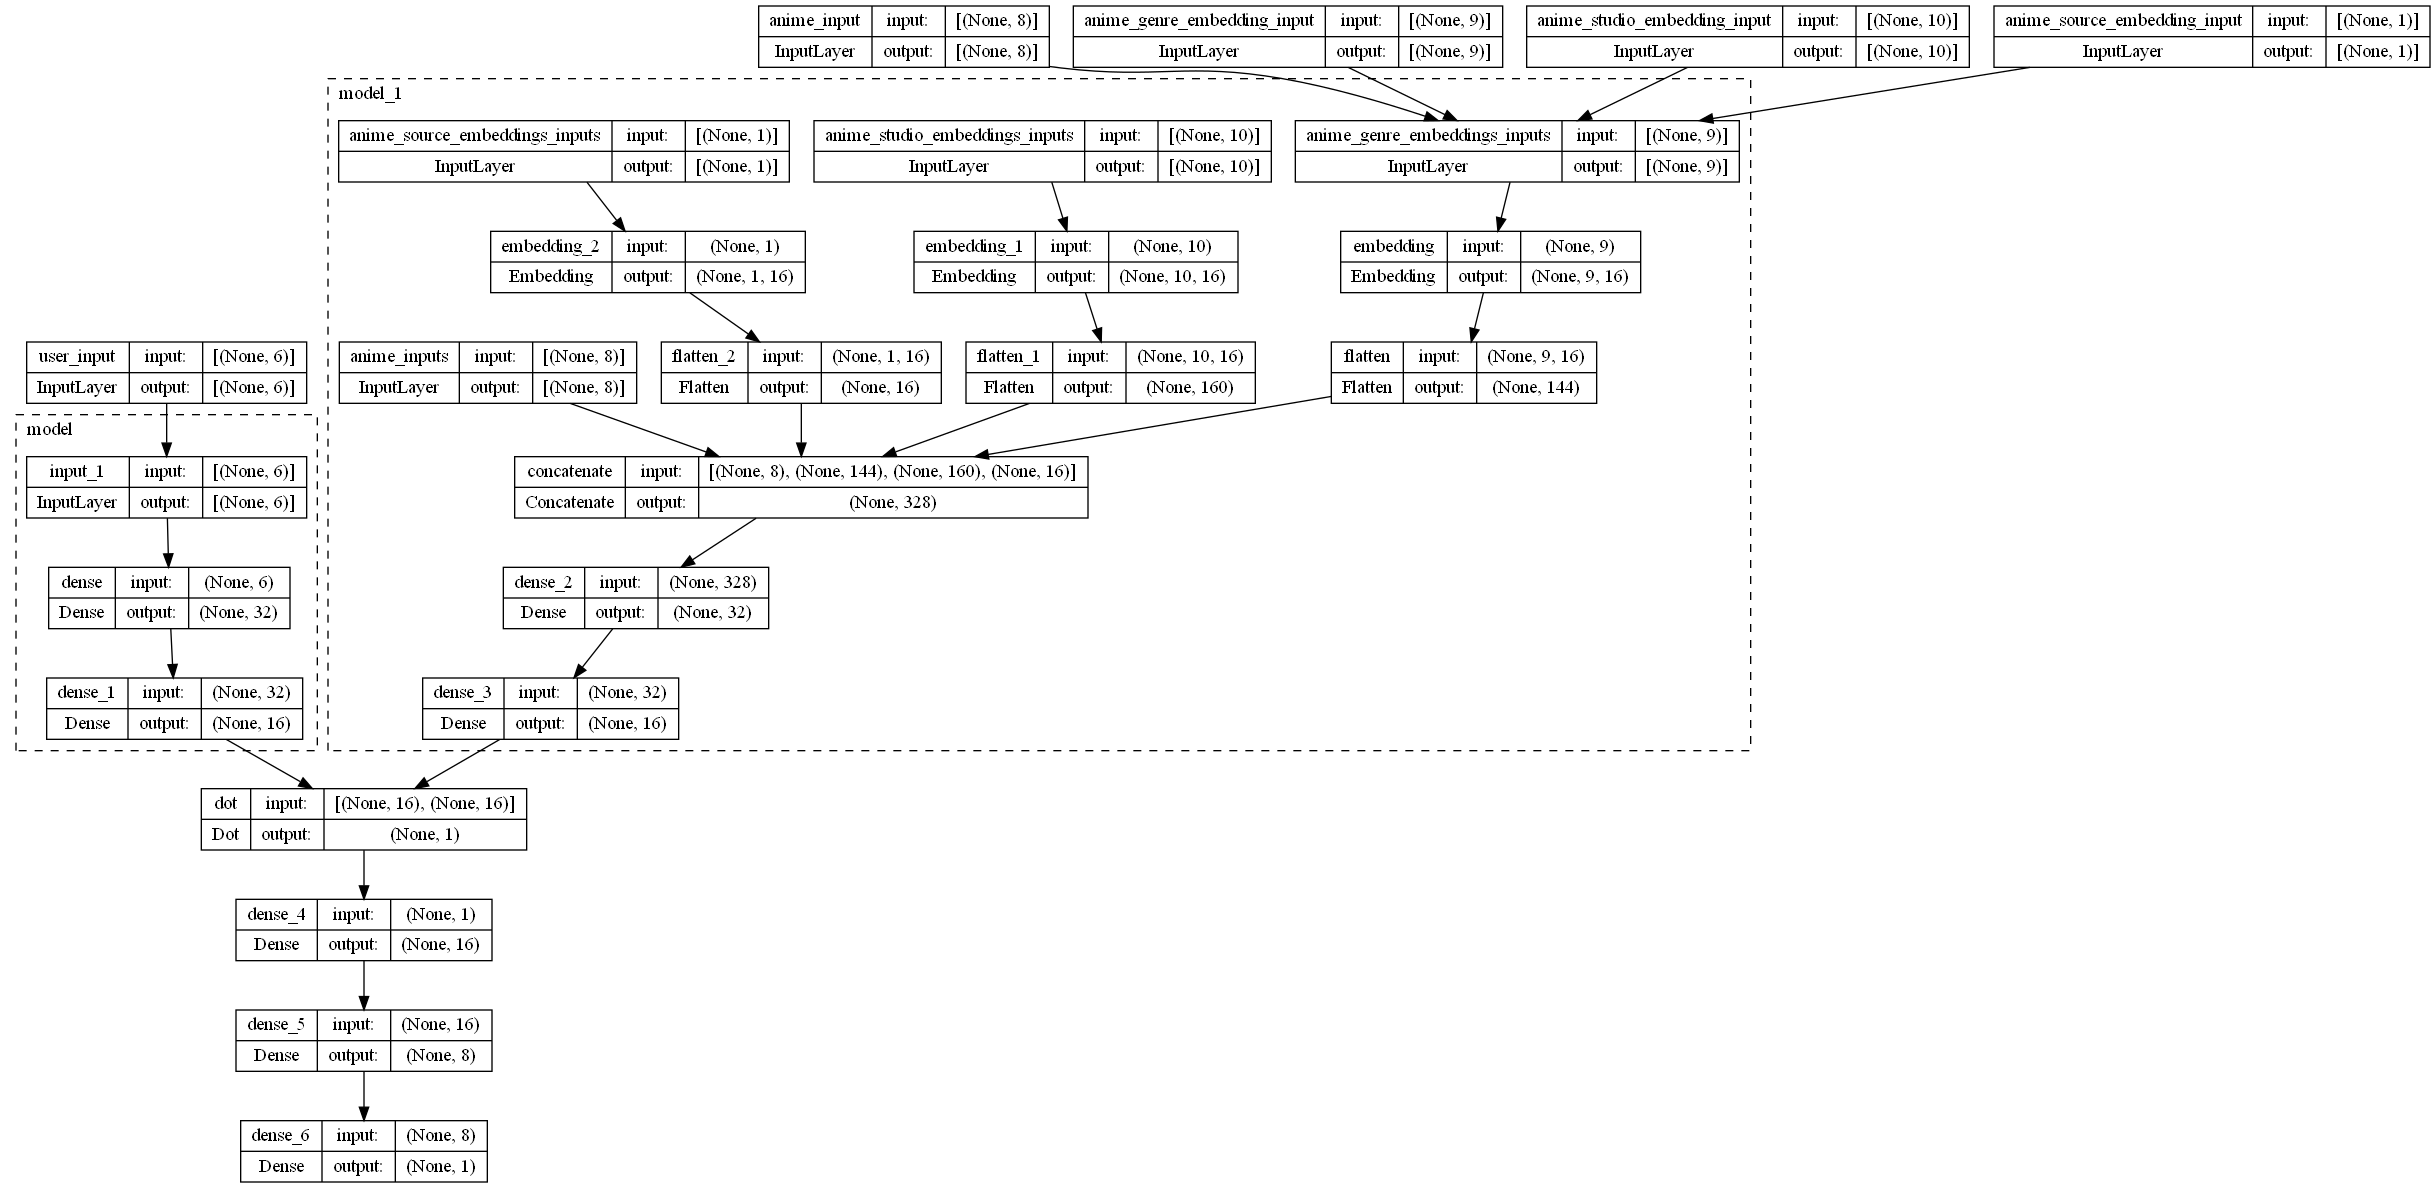

In [31]:
import pydot
import pydotplus
import graphviz
tf.keras.utils.plot_model(
model3,
to_file="model.png",
show_shapes=True,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
)


In [32]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [33]:

history=model3.fit(train_dataset, epochs=6,validation_data=val_dataset)

Epoch 1/6
1438/1438 [==============================] - 287s 198ms/step - loss: 0.6722 - mae: 0.6460 - val_loss: 0.5862 - val_mae: 0.5849
Epoch 2/6
1438/1438 [==============================] - 282s 196ms/step - loss: 0.6150 - mae: 0.6178 - val_loss: 0.5753 - val_mae: 0.5791
Epoch 3/6
1438/1438 [==============================] - 279s 194ms/step - loss: 0.6096 - mae: 0.6149 - val_loss: 0.5753 - val_mae: 0.5802
Epoch 4/6
1438/1438 [==============================] - 278s 193ms/step - loss: 0.6083 - mae: 0.6146 - val_loss: 0.5744 - val_mae: 0.5788
Epoch 5/6
1438/1438 [==============================] - 286s 199ms/step - loss: 0.6082 - mae: 0.6139 - val_loss: 0.5790 - val_mae: 0.5809
Epoch 6/6
1438/1438 [==============================] - 280s 195ms/step - loss: 0.6071 - mae: 0.6120 - val_loss: 0.5747 - val_mae: 0.5794


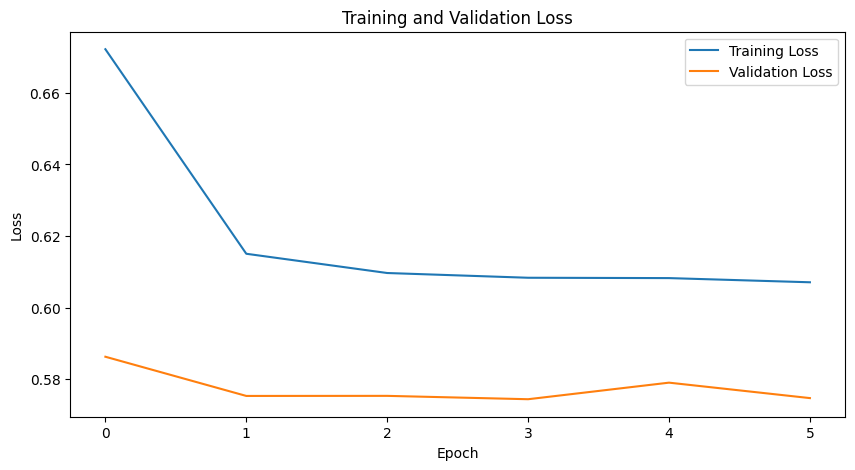

In [34]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
batch_size = 16384
test_dataset=test_dataset1.shuffle(batch_size)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:
model3.evaluate(test_dataset)

8/8 [==============================] - 101s 110ms/step - loss: 0.5768 - mae: 0.5775


[0.5768083333969116, 0.5775251388549805]

In [38]:
model2.get_weights()

[array([[ 5.62825380e-03,  9.91345104e-03, -1.10392766e-02,
          9.54613090e-03,  4.28834930e-02, -5.84538188e-03,
          5.27394190e-03,  2.14367732e-02, -1.09464033e-02,
          1.99142732e-02, -1.10869920e-02,  9.95585322e-03,
          3.48102488e-02, -1.63817797e-02,  3.46202813e-02,
          5.19492722e-04],
        [-3.36411744e-02, -4.52087522e-02,  1.22640021e-02,
          1.69651620e-02,  1.74281485e-02, -1.01978891e-02,
         -2.52470374e-02,  4.39139642e-02,  2.92385109e-02,
         -1.03427880e-02,  3.15418877e-02,  1.45793445e-02,
         -3.49535830e-02,  2.66151503e-03, -3.76952291e-02,
          1.00169070e-02],
        [-1.13230109e-01, -1.83368567e-02, -1.95923582e-01,
          1.08080685e-01,  7.57813826e-02, -5.30283935e-02,
          1.81446657e-01,  6.98020458e-02,  1.48174046e-02,
         -1.41629711e-01, -5.26574105e-02,  4.28185165e-02,
          1.16613664e-01,  7.89154544e-02, -1.12268880e-01,
          3.13983522e-02],
        [ 1.0995087

In [35]:
df=np.load('F:/merged_half2.npy')

In [36]:
user_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,3:9])
anime_metadata_dataset = tf.data.Dataset.from_tensor_slices(df[:,9:9+anime_input_shape])
anime_studio_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape:9+anime_input_shape+studio_max_length])
anime_genre_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,9+anime_input_shape+studio_max_length:9+anime_input_shape+studio_max_length+genre_max_length])
anime_source_embedding_dataset = tf.data.Dataset.from_tensor_slices(df[:,-1:])
ratings_dataset = tf.data.Dataset.from_tensor_slices(df[:,2])

In [37]:
dataset = tf.data.Dataset.zip(({'user_input':user_metadata_dataset, 'anime_input':anime_metadata_dataset,'anime_genre_embedding_input':anime_genre_embedding_dataset,'anime_studio_embedding_input':anime_studio_embedding_dataset,'anime_source_embedding_input':anime_source_embedding_dataset}, ratings_dataset))


In [38]:
size = dataset.cardinality().numpy()

In [39]:
size

29984240

In [40]:
#dataset=dataset.shuffle(int(size ))
train_size = int(0.99 * size)  # Assuming an 80-10-10 split
val_size =int(0.005*size)
train_dataset = dataset.take(train_size)    
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset2 = dataset.skip(train_size).skip(val_size)


In [41]:
batch_size = 16384
val_dataset=val_dataset.shuffle(batch_size)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [42]:
val_dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset element_spec=({'user_input': TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), 'anime_input': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), 'anime_genre_embedding_input': TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), 'anime_studio_embedding_input': TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), 'anime_source_embedding_input': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>>

In [43]:
batch_size = 16384
train_dataset=train_dataset.shuffle(batch_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
train_dataset.cardinality

<bound method DatasetV2.cardinality of <PrefetchDataset element_spec=({'user_input': TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), 'anime_input': TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), 'anime_genre_embedding_input': TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), 'anime_studio_embedding_input': TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), 'anime_source_embedding_input': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>>

In [45]:

history=model3.fit(train_dataset, epochs=3,validation_data=val_dataset)

Epoch 1/3
1812/1812 [==============================] - 354s 195ms/step - loss: 0.9267 - mae: 0.9090 - val_loss: 0.9259 - val_mae: 0.9080
Epoch 2/3
1812/1812 [==============================] - 352s 194ms/step - loss: 0.9262 - mae: 0.9084 - val_loss: 0.9259 - val_mae: 0.9074
Epoch 3/3
1812/1812 [==============================] - 351s 193ms/step - loss: 0.9258 - mae: 0.9080 - val_loss: 0.9252 - val_mae: 0.9087


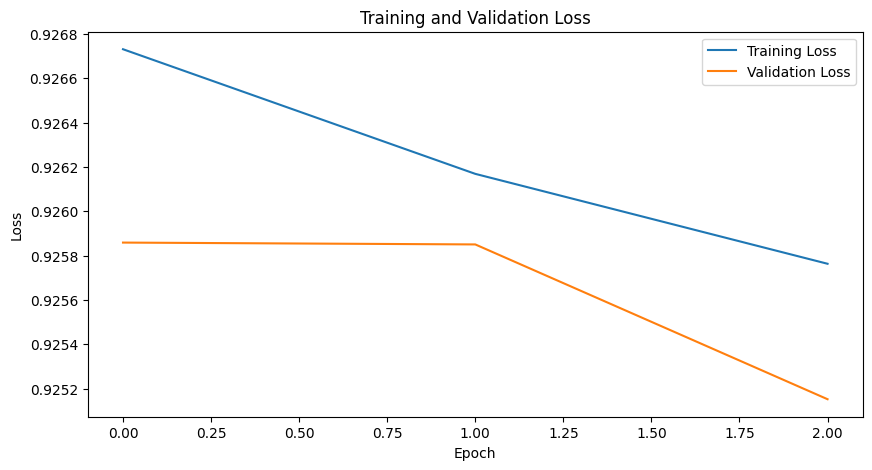

In [46]:
# Plot training loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'][:], label='Training Loss')
plt.plot(history.history['val_loss'][:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
test_dataset=test_dataset2.concatenate(test_dataset1)

In [51]:
batch_size = 16384
test_dataset=test_dataset.shuffle(batch_size)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [32]:
model3=tf.keras.models.load_model('models/merged_model.keras')

In [52]:
model3.evaluate(test_dataset)

19/19 [==============================] - 266s 7s/step - loss: 0.9254 - mae: 0.9086


[0.9254308342933655, 0.9085860252380371]

In [39]:
model1.save('models/user_model_2.keras')

In [40]:
model2.save('models/anime_model_2.keras')

In [41]:
model3.save('models/merged_model_2.keras')

In [42]:
test=tf.keras.models.load_model('models/anime_model_2.keras')

In [43]:
test.get_weights()

[array([[ 5.62825380e-03,  9.91345104e-03, -1.10392766e-02,
          9.54613090e-03,  4.28834930e-02, -5.84538188e-03,
          5.27394190e-03,  2.14367732e-02, -1.09464033e-02,
          1.99142732e-02, -1.10869920e-02,  9.95585322e-03,
          3.48102488e-02, -1.63817797e-02,  3.46202813e-02,
          5.19492722e-04],
        [-3.36411744e-02, -4.52087522e-02,  1.22640021e-02,
          1.69651620e-02,  1.74281485e-02, -1.01978891e-02,
         -2.52470374e-02,  4.39139642e-02,  2.92385109e-02,
         -1.03427880e-02,  3.15418877e-02,  1.45793445e-02,
         -3.49535830e-02,  2.66151503e-03, -3.76952291e-02,
          1.00169070e-02],
        [-1.13230109e-01, -1.83368567e-02, -1.95923582e-01,
          1.08080685e-01,  7.57813826e-02, -5.30283935e-02,
          1.81446657e-01,  6.98020458e-02,  1.48174046e-02,
         -1.41629711e-01, -5.26574105e-02,  4.28185165e-02,
          1.16613664e-01,  7.89154544e-02, -1.12268880e-01,
          3.13983522e-02],
        [ 1.0995087

In [44]:
model2.get_weights()

[array([[ 5.62825380e-03,  9.91345104e-03, -1.10392766e-02,
          9.54613090e-03,  4.28834930e-02, -5.84538188e-03,
          5.27394190e-03,  2.14367732e-02, -1.09464033e-02,
          1.99142732e-02, -1.10869920e-02,  9.95585322e-03,
          3.48102488e-02, -1.63817797e-02,  3.46202813e-02,
          5.19492722e-04],
        [-3.36411744e-02, -4.52087522e-02,  1.22640021e-02,
          1.69651620e-02,  1.74281485e-02, -1.01978891e-02,
         -2.52470374e-02,  4.39139642e-02,  2.92385109e-02,
         -1.03427880e-02,  3.15418877e-02,  1.45793445e-02,
         -3.49535830e-02,  2.66151503e-03, -3.76952291e-02,
          1.00169070e-02],
        [-1.13230109e-01, -1.83368567e-02, -1.95923582e-01,
          1.08080685e-01,  7.57813826e-02, -5.30283935e-02,
          1.81446657e-01,  6.98020458e-02,  1.48174046e-02,
         -1.41629711e-01, -5.26574105e-02,  4.28185165e-02,
          1.16613664e-01,  7.89154544e-02, -1.12268880e-01,
          3.13983522e-02],
        [ 1.0995087